# Feature selection with RFE


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scripts.tracks import get_tracks
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from scripts.ROC import get_ROC, plot_ROC_curve

pd.set_option('display.max_columns', None)

#### Unpickle FE dataframe

In [2]:
data = pd.read_pickle('/home/alepfu/Desktop/dataset/pickle/event000001000_FE.pkl')
data.shape

(103305, 54)

#### Pick a sample of tracks

In [3]:
N_tracks = 100
data = get_tracks(data, N_tracks=N_tracks, drop_zero_weights=False, drop_zero_id=False, factorize_particle_id=False)
print(data.shape)

(988, 54)


#### Set features for use in feature selection
We can only make use of information from the hit level and the engineered features.

In [4]:
data = data[['hit_id','particle_id','x','y','z','volume_id','layer_id','module_id',
             'x_scaled','y_scaled','z_scaled','r_cyl','theta','theta_atan2','r_sph','phi','phi_atan2',
             'x_r_cyl','y_r_cyl','z_r_cyl','x_r_sph','y_r_sph','z_r_sph',
             'n_pixel','signal_pixel','phi_pixel','theta_pixel','path_pixel','u_pixel','v_pixel',
             'vol_inner','vol_short','vol_long','vol_lay_mul','vol_lay_add','vol_lay_concat',
             'z_dir','cos_dist_rc','cos_dist_lc']]

print(data.shape)

(988, 39)


## RFE with tree-based methods

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html):
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [7]:
%%time

X = data.loc[:, data.columns != 'particle_id']
y = data[['particle_id']].values.ravel()

N_rfe_features = 10

dec_tree_clf = DecisionTreeClassifier()
dec_tree_rfe = RFE(estimator=dec_tree_clf, step=1, n_features_to_select=N_rfe_features)
dec_tree_rfe.fit(X, y);

ex_tree_clf = ExtraTreesClassifier()
ex_tree_rfe = RFE(estimator=ex_tree_clf, step=1, n_features_to_select=N_rfe_features)
ex_tree_rfe.fit(X, y);

forest_clf = RandomForestClassifier()
forest_rfe = RFE(estimator=forest_clf, step=1, n_features_to_select=N_rfe_features)
forest_rfe.fit(X, y);

CPU times: user 4.47 s, sys: 0 ns, total: 4.47 s
Wall time: 4.47 s


#### Visualizing RFE feature rankings

Since RFE ranks the best k scoring features with rank 1 (and all others with their level of elimination), we use 1/rank in the plot to indicate the feature's performance.

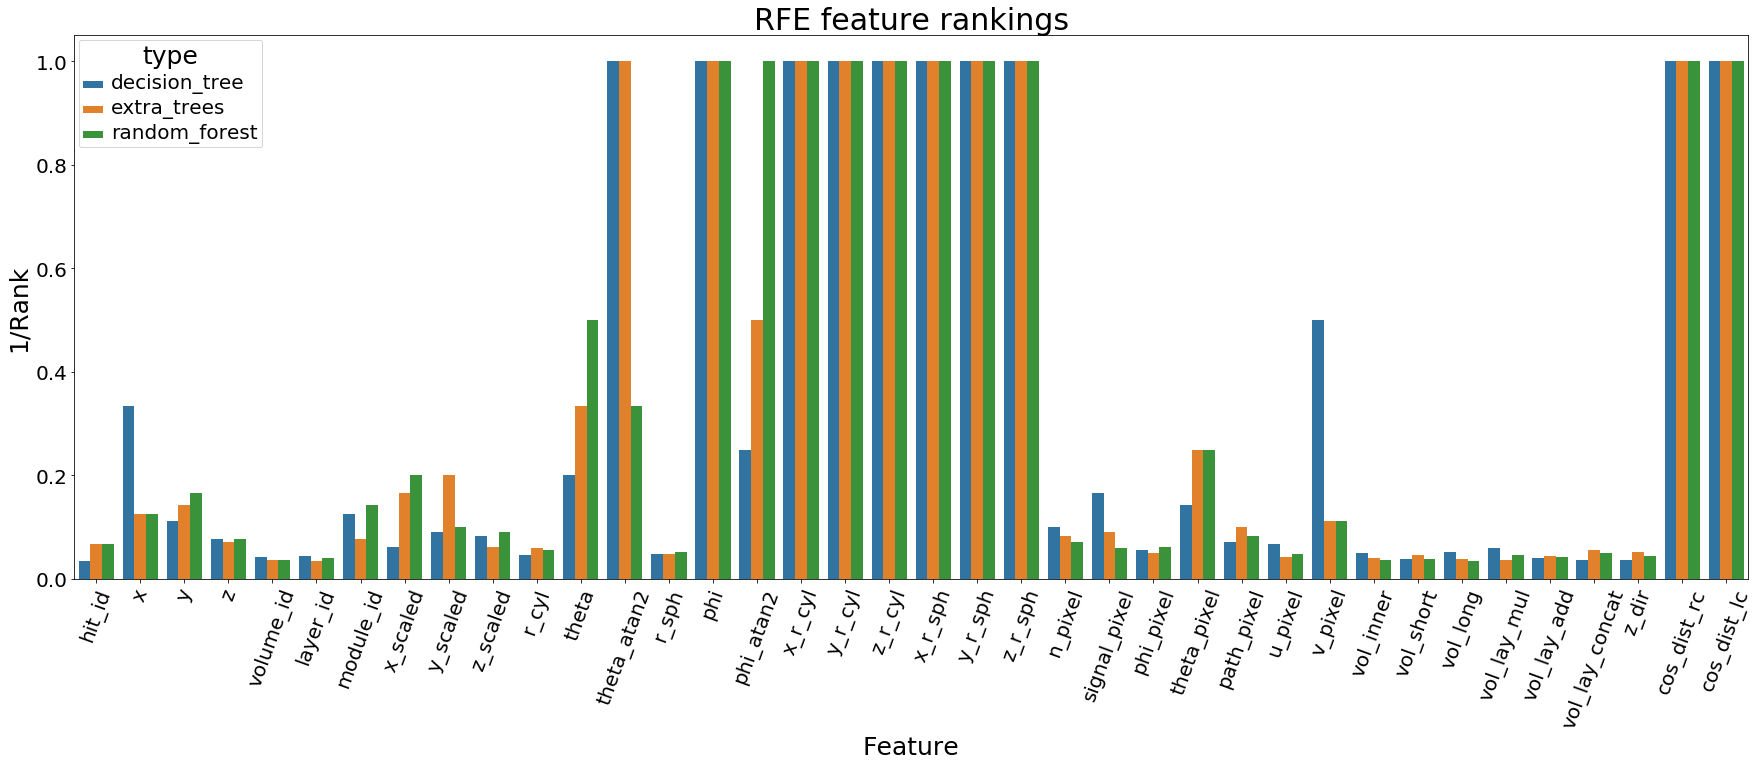

In [6]:
a1 = np.stack((X.columns.values, 1./dec_tree_rfe.ranking_, np.full(X.columns.values.shape, 'decision_tree')), axis=1)
a2 = np.stack((X.columns.values, 1./ex_tree_rfe.ranking_, np.full(X.columns.values.shape, 'extra_trees')), axis=1)
a3 = np.stack((X.columns.values, 1./forest_rfe.ranking_, np.full(X.columns.values.shape, 'random_forest')), axis=1)

tree_ranking = pd.DataFrame(np.concatenate((a1, a2, a3)), columns=['feature','rank','type'])

plt.figure(figsize=(30,10))
ax = sns.barplot(x='feature', y='rank', hue='type', data=tree_ranking);
ax.set_title('RFE feature rankings', fontsize=30);
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);
ax.set_xlabel('Feature', fontsize=25);
ax.set_ylabel('1/Rank',fontsize=25);
ax.tick_params(labelsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='25')
plt.show()